In [114]:
import cf_xarray  # noqa: F401
import copernicusmarine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.standard.coordinates import new_latitude, new_longitude, new_time

xr.set_options(display_expand_data=False, keep_attrs=True)

## Read and transforme the raw file


In [115]:
path_to_zooplankton = "../data/phd/BATS/RAW/BATS_zooplankton.xlsx"
date_column = [2]
time_column = [8]
latitude_column = [4, 5]
longitude_column = [6, 7]
size_fraction_column = [13]
dry_weight_column = [17]

In [116]:
bats_raw = pd.read_excel(path_to_zooplankton, skiprows=35)
bats_raw = bats_raw[
    date_column + time_column + latitude_column + longitude_column + size_fraction_column + dry_weight_column
]
bats_raw

,2,8,4,5,6,7,13,17
0,19940406,1558,31,33.890,63,52.450,200,1.55
1,19940406,1558,31,33.890,63,52.450,500,0.89
2,19940406,1558,31,33.890,63,52.450,1000,0.81
3,19940406,1558,31,33.890,63,52.450,2000,0.70
4,19940406,1558,31,33.890,63,52.450,5000,0.27
...,...,...,...,...,...,...,...,...
7294,20221213,2243,31,38.242,64,12.072,200,0.26
7295,20221213,2243,31,38.242,64,12.072,500,0.45
7296,20221213,2243,31,38.242,64,12.072,1000,0.30
7297,20221213,2243,31,38.242,64,12.072,2000,0.17


### Manage coordinates


In [117]:
date = pd.to_datetime(bats_raw[date_column[0]], format="%Y%m%d")
latitude = bats_raw[latitude_column[0]] + (bats_raw[latitude_column[1]] / 100)
longitude = -(bats_raw[longitude_column[0]] + (bats_raw[longitude_column[1]] / 100))
time = pd.to_datetime(bats_raw[time_column[0]].apply(lambda x: str(x).zfill(4)), format="%H%M")
time = date + pd.to_timedelta(time.dt.hour, unit="h") + pd.to_timedelta(time.dt.minute, unit="m")
size = bats_raw[size_fraction_column[0]]

### Generate the DataArray


In [118]:
data = pd.DataFrame(
    {
        "time": time,
        "latitude": latitude,
        "longitude": longitude,
        "size": size,
        "dry_weight": bats_raw[dry_weight_column[0]],
    }
)
data["latitude"] = data["latitude"].round(1)
data["longitude"] = data["longitude"].round(1)
data = data.replace(-999, np.nan)
data = data.groupby(["time", "latitude", "longitude", "size"]).sum()

In [119]:
bats_ds = xr.Dataset.from_dataframe(data)
bats_ds.latitude.attrs = new_latitude(latitude).attrs
bats_ds.longitude.attrs = new_longitude(longitude).attrs
bats_ds.time.attrs = new_time(time).attrs
bats_ds["dry_weight"].attrs = {
    "standard_name": "zooplankton_dry_weight",
    "long_name": "Zooplankton dry weight",
    "units": "mg/m^3",
}
bats_ds["dry_weight_all_sized"] = bats_ds["dry_weight"].sum(dim="size", skipna=True)
bats_ds["dry_weight_all_sized"].attrs["description"] = "Sum of all size fractions"
# replace all 0 values with nan
bats_ds["dry_weight_all_sized"] = bats_ds["dry_weight_all_sized"].where(bats_ds["dry_weight_all_sized"] > 0)
bats_ds["size"].attrs = {
    "standard_name": "size_fraction",
    "long_name": "Size fraction",
    "units": "micrometers",
}
bats_ds

<xarray.Dataset> Size: 2MB
Dimensions:               (time: 1456, latitude: 5, longitude: 6, size: 5)
Coordinates:
  * time                  (time) datetime64[ns] 12kB 1994-04-06T15:58:00 ... ...
  * latitude              (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude             (longitude) float64 48B -64.3 -64.2 ... -63.6 -63.5
  * size                  (size) float64 40B 200.0 500.0 1e+03 2e+03 5e+03
Data variables:
    dry_weight            (time, latitude, longitude, size) float64 2MB nan ....
    dry_weight_all_sized  (time, latitude, longitude) float64 349kB nan ... nan

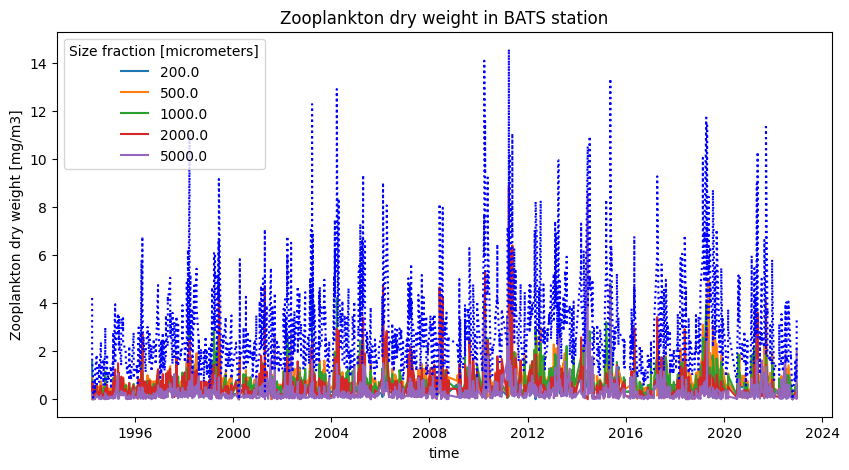

In [120]:
plt.figure(figsize=(10, 5))
bats_ds["dry_weight"].sum(["latitude", "longitude"]).plot.line(x="time", hue="size")
bats_ds["dry_weight_all_sized"].sum(["latitude", "longitude"]).plot.line("b:", x="time")
plt.title("Zooplankton dry weight in BATS station")
plt.ylabel("Zooplankton dry weight [mg/m3]")
plt.show()

## Generate the zooplankton biomasse for day and night


In [121]:
night_condition = (bats_ds.time.dt.hour > 18) | (bats_ds.time.dt.hour < 6)
bats_ds["is_night"] = xr.where(night_condition, True, False)
bats_ds = bats_ds.set_coords("is_night")
bats_ds.is_night.attrs = {
    "flag_values": [True, False],
    "flag_meanings": "night day",
    "standard_name": "is_night",
    "long_name": "Is night",
}
bats_ds

<xarray.Dataset> Size: 2MB
Dimensions:               (time: 1456, latitude: 5, longitude: 6, size: 5)
Coordinates:
  * time                  (time) datetime64[ns] 12kB 1994-04-06T15:58:00 ... ...
  * latitude              (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude             (longitude) float64 48B -64.3 -64.2 ... -63.6 -63.5
  * size                  (size) float64 40B 200.0 500.0 1e+03 2e+03 5e+03
    is_night              (time) bool 1kB False False True ... False True True
Data variables:
    dry_weight            (time, latitude, longitude, size) float64 2MB nan ....
    dry_weight_all_sized  (time, latitude, longitude) float64 349kB nan ... nan

---


In [131]:
data = [
    bats_ds.dry_weight_all_sized[bats_ds.is_night].expand_dims({"day_phase": ["night"]}),
    bats_ds.dry_weight_all_sized[~bats_ds.is_night].expand_dims({"day_phase": ["day"]}),
]
attrs = {
    "long_name": "Zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "location": "BATS",
    "resampling": "monthly",
    "interpolation": "linear",
}
bats_zooplankton = xr.concat(data, dim="day_phase")
bats_zooplankton = bats_zooplankton.resample(time="1ME").mean().interpolate_na("time")
bats_zooplankton.attrs = attrs
bats_zooplankton

<xarray.DataArray 'dry_weight_all_sized' (day_phase: 2, time: 345, latitude: 5,
                                          longitude: 6)> Size: 166kB
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates:
  * latitude   (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude  (longitude) float64 48B -64.3 -64.2 -64.1 -64.0 -63.6 -63.5
  * day_phase  (day_phase) object 16B 'night' 'day'
  * time       (time) datetime64[ns] 3kB 1994-04-30 1994-05-31 ... 2022-12-31
Attributes:
    long_name:      Zooplankton dry weight
    standard_name:  zooplankton_dry_weight
    units:          mg/m3
    location:       BATS
    resampling:     monthly
    interpolation:  linear

# Migrant Zooplankton


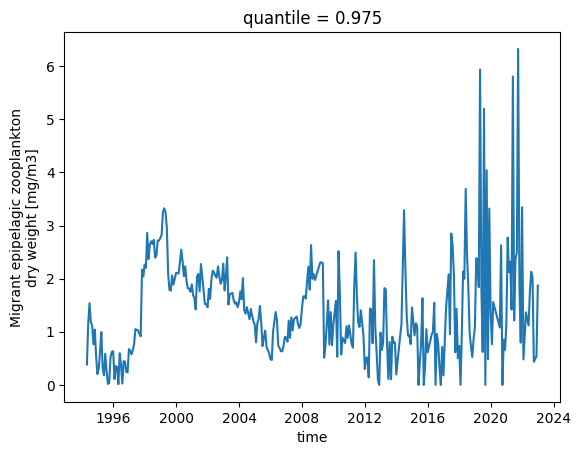

In [123]:
quantile = 0.975
zpk_migrant = bats_zooplankton.sel(day_phase="night") - bats_zooplankton.sel(day_phase="day")
outliers = zpk_migrant.quantile(quantile)
zpk_migrant = xr.where(zpk_migrant < 0, 0, zpk_migrant)
zpk_migrant = xr.where(zpk_migrant > outliers, outliers, zpk_migrant)
zpk_migrant.attrs = {
    "long_name": "Migrant epipelagic zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "interpolation": "linear",
    "resampling": "monthly",
    "ceil": "97.5 quantile",
    "lower threshold": "0",
    "location": "BATS",
}
zpk_migrant.mean(["latitude", "longitude"]).plot()

# Zooplankton epipelagic non-migrant


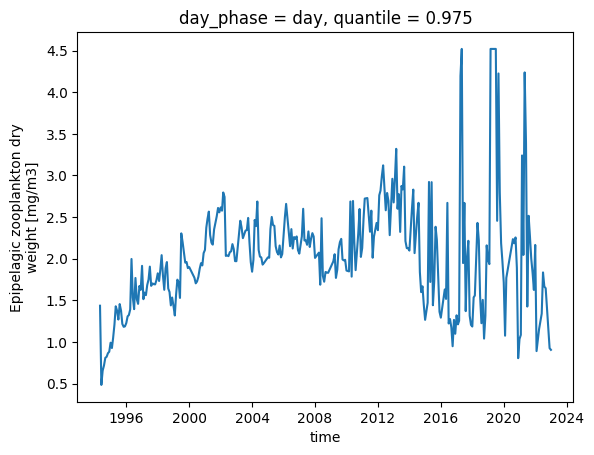

In [124]:
zooplankton_epi = bats_zooplankton.sel(day_phase="day").resample(time="1ME").mean().interpolate_na("time")
zooplankton_epi.name = "zooplankton_epi"
outliers = zooplankton_epi.quantile(quantile)
zooplankton_epi = xr.where(zooplankton_epi < 0, 0, zooplankton_epi)
zooplankton_epi = xr.where(zooplankton_epi > outliers, outliers, zooplankton_epi)
zooplankton_epi.attrs = {
    "long_name": "Epipelagic zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "interpolation": "linear",
    "resampling": "monthly",
    "ceil": "97.5 quantile",
    "lower threshold": "0",
    "location": "BATS",
}
zooplankton_epi.mean(["latitude", "longitude"]).plot()

---

# Add the layers limits


In [125]:
data_limits_raw = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i",
    dataset_version="202211",
    minimum_latitude=31,
    maximum_latitude=32,
    minimum_longitude=-64,
    maximum_longitude=-63,
    start_datetime="1998-01-01",
    end_datetime="2020-02-29",
    variables=["pelagic_layer_depth"],
)
data_limits_raw

INFO - 2024-04-30T01:47:18Z - You forced selection of dataset version "202211"
INFO - 2024-04-30T01:47:18Z - Dataset part was not specified, the first one was selected: "default"


INFO - 2024-04-30T01:47:34Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset> Size: 33MB
Dimensions:              (depth: 3, latitude: 13, longitude: 13, time: 8095)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float32 52B 31.0 31.08 31.17 ... 31.92 32.0
  * longitude            (longitude) float32 52B -64.0 -63.92 ... -63.08 -63.0
  * time                 (time) datetime64[ns] 65kB 1998-01-01 ... 2020-02-29
Data variables:
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 33MB ...
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

In [126]:
data_limits = data_limits_raw.cf.sel(Y=slice(31.2468, 31.5847), X=slice(-63.5993, -63.004))
data_limits = data_limits.cf.mean(dim=["X", "Y"])
data_limits

<xarray.Dataset> Size: 259kB
Dimensions:              (depth: 3, time: 8095)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * time                 (time) datetime64[ns] 65kB 1998-01-01 ... 2020-02-29
Data variables:
    pelagic_layer_depth  (time, depth) float64 194kB 111.8 335.4 ... 332.1 774.8
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

In [127]:
data_limits = data_limits.resample(time="1ME").mean().interpolate_na("time")
data_limits

<xarray.Dataset> Size: 9kB
Dimensions:              (depth: 3, time: 266)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * time                 (time) datetime64[ns] 2kB 1998-01-31 ... 2020-02-29
Data variables:
    pelagic_layer_depth  (time, depth) float64 6kB 113.5 340.5 ... 331.5 773.4
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

---


# Gathering data


In [139]:
final_ds = xr.Dataset(
    {
        "zooplankton": bats_zooplankton,
        "zooplankton_epi": zooplankton_epi,
        "zooplankton_migrant": zpk_migrant,
    }
)
final_ds = xr.merge([final_ds, data_limits])
final_ds.time.attrs = new_time(final_ds.time.data).attrs
final_ds

<xarray.Dataset> Size: 342kB
Dimensions:              (latitude: 5, longitude: 6, day_phase: 2, time: 345,
                          depth: 3)
Coordinates:
  * latitude             (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude            (longitude) float64 48B -64.3 -64.2 ... -63.6 -63.5
  * day_phase            (day_phase) object 16B 'night' 'day'
  * time                 (time) datetime64[ns] 3kB 1994-04-30 ... 2022-12-31
    quantile             float64 8B 0.975
  * depth                (depth) int32 12B 1 2 3
Data variables:
    zooplankton          (day_phase, time, latitude, longitude) float64 166kB ...
    zooplankton_epi      (time, latitude, longitude) float64 83kB nan ... nan
    zooplankton_migrant  (time, latitude, longitude) float64 83kB nan ... nan
    pelagic_layer_depth  (time, depth) float64 8kB nan nan nan ... nan nan nan

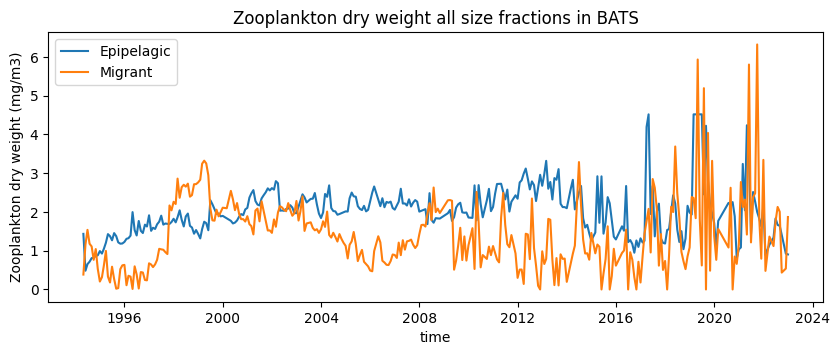

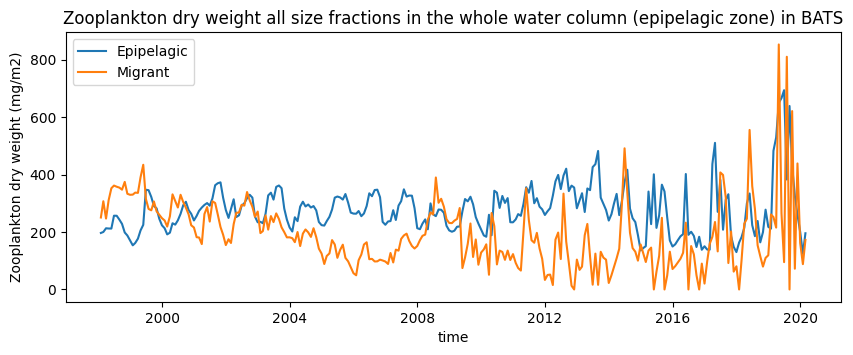

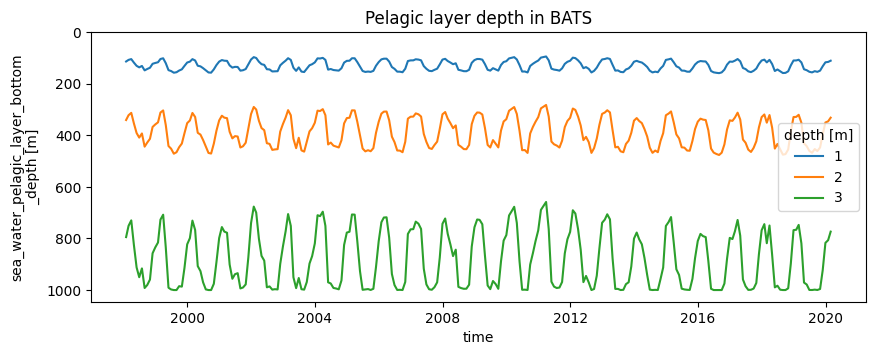

In [141]:
plt.figure(figsize=(10, 3.5))
final_ds["zooplankton_epi"].mean(["latitude", "longitude"]).plot(label="Epipelagic")
final_ds["zooplankton_migrant"].mean(["latitude", "longitude"]).plot(label="Migrant")
plt.ylabel("Zooplankton dry weight (mg/m3)")
plt.title("Zooplankton dry weight all size fractions in BATS")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3.5))
(final_ds["zooplankton_epi"] * final_ds["pelagic_layer_depth"].sel(depth=1)).mean(["latitude", "longitude"]).plot(
    label="Epipelagic"
)
(final_ds["zooplankton_migrant"] * final_ds["pelagic_layer_depth"].sel(depth=1)).mean(["latitude", "longitude"]).plot(
    label="Migrant"
)
plt.title("Zooplankton dry weight all size fractions in the whole water column (epipelagic zone) in BATS")
plt.ylabel("Zooplankton dry weight (mg/m2)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3.5))
ax = final_ds["pelagic_layer_depth"].plot.line(x="time")
plt.ylim(0, None)
plt.gca().invert_yaxis()
plt.title("Pelagic layer depth in BATS")
plt.show()

# Save the processed data


In [136]:
final_ds.to_netcdf("../data/phd/BATS/PROCESSED/BATS_zooplankton.nc", mode="w")